## [Luis Alejandro Rodríguez Arenas](https://luigitoby.github.io/)  
## Cod. 202321287 
## Parte de G4
## Laboratorio 1 - Pre-informe

## Importación de librerías necesarias

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sympy import symbols, Matrix, pi, cos, sin, simplify, eye, solve, acos, asin,  latex, atan2, pprint, init_printing, Derivative, sqrt
from sympy.physics.mechanics import ReferenceFrame, dynamicsymbols, init_vprinting, Point

# Formato mathjax, porque me gusta mejor estas derivadas
init_vprinting(use_latex='mathjax')

ModuleNotFoundError: No module named 'numpy'

# 2D

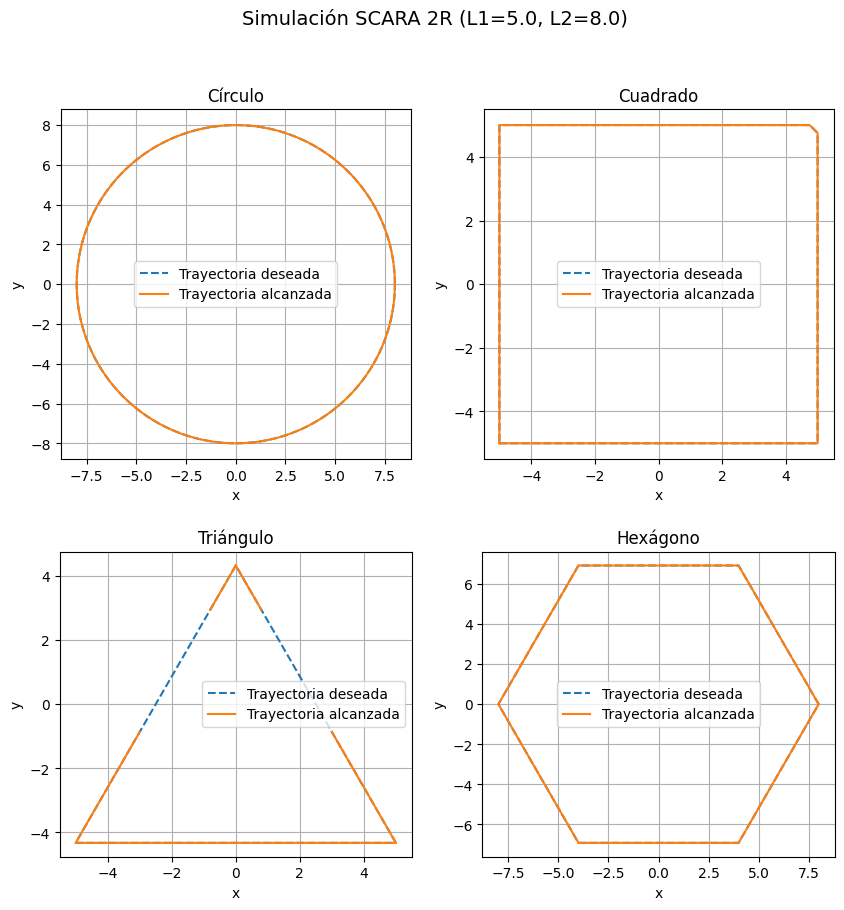

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Cinemática inversa (IK)
def cinematica_inversa(x, y, L1, L2, branch="down"):
    d2 = x*x + y*y
    if d2 > (L1 + L2)**2 or d2 < (L1 - L2)**2:
        return None
    c2 = (d2 - L1**2 - L2**2) / (2.0 * L1 * L2)
    c2 = np.clip(c2, -1.0, 1.0)
    theta2 = np.arccos(c2)
    if branch == "up":
        theta2 = -theta2
    k1 = L1 + L2 * np.cos(theta2)
    k2 = L2 * np.sin(theta2)
    theta1 = np.arctan2(y, x) - np.arctan2(k2, k1)
    return np.degrees(theta1), np.degrees(theta2)

# Cinemática directa (FK)
def cinematica_directa(theta1_deg, theta2_deg, L1, L2):
    t1 = np.radians(theta1_deg)
    t2 = np.radians(theta2_deg)
    x = L1*np.cos(t1) + L2*np.cos(t1 + t2)
    y = L1*np.sin(t1) + L2*np.sin(t1 + t2)
    return x, y

# Trayectorias
def trayectoria_circulo(radio=8.0, n_puntos=200):
    t = np.linspace(0, 2*np.pi, n_puntos, endpoint=True)
    return [(radio*np.cos(tt), radio*np.sin(tt)) for tt in t]

def trayectoria_cuadrado(lado=10.0, n_puntos=160):
    pts = []
    seg = n_puntos//4
    xs = np.linspace(-lado/2,  lado/2, seg, endpoint=False)
    ys = np.linspace(-lado/2,  lado/2, seg, endpoint=False)
    pts += [(x, -lado/2) for x in xs]
    pts += [( lado/2, y) for y in ys]
    pts += [(x,  lado/2) for x in xs[::-1]]
    pts += [(-lado/2, y) for y in ys[::-1]]
    pts.append(pts[0])
    return pts

def trayectoria_triangulo(lado=10.0, n_puntos=150):
    h = np.sqrt(3)/2 * lado
    V = [(0, h/2), (-lado/2, -h/2), (lado/2, -h/2), (0, h/2)]
    seg = n_puntos//3
    pts = []
    for i in range(3):
        x1, y1 = V[i]
        x2, y2 = V[i+1]
        xs = np.linspace(x1, x2, seg, endpoint=False)
        ys = np.linspace(y1, y2, seg, endpoint=False)
        pts += list(zip(xs, ys))
    pts.append(V[0])
    return pts

def trayectoria_hexagono(radio=8.0, n_puntos=180):
    V = [(radio*np.cos(i*np.pi/3), radio*np.sin(i*np.pi/3)) for i in range(6)]
    V.append(V[0])
    seg = n_puntos//6
    pts = []
    for i in range(6):
        x1, y1 = V[i]
        x2, y2 = V[i+1]
        xs = np.linspace(x1, x2, seg, endpoint=False)
        ys = np.linspace(y1, y2, seg, endpoint=False)
        pts += list(zip(xs, ys))
    pts.append(V[0])
    return pts

# Simulación SCARA
def simular_robot_SCARA(L1, L2, T, branch="down"):
    angulos, tray_real = [], []
    for (x, y) in T:
        th = cinematica_inversa(x, y, L1, L2, branch=branch)
        if th is None:
            angulos.append(None)
            tray_real.append(None)
        else:
            x_r, y_r = cinematica_directa(th[0], th[1], L1, L2)
            angulos.append(th)
            tray_real.append((x_r, y_r))
    return angulos, tray_real

# Parámetros del robot
L1, L2 = 5.0, 8.0

# Diccionario de trayectorias
trayectorias = {
    "Círculo": trayectoria_circulo(radio=8.0),
    "Cuadrado": trayectoria_cuadrado(lado=10.0),
    "Triángulo": trayectoria_triangulo(lado=10.0),
    "Hexágono": trayectoria_hexagono(radio=8.0)
}

# Gráficas
fig, axs = plt.subplots(2,2,figsize=(10,10))
axs = axs.flatten()

for i, (nombre, tray) in enumerate(trayectorias.items()):
    ang, tray_real = simular_robot_SCARA(L1, L2, tray, branch="down")
    xd, yd = zip(*tray)
    xr, yr = zip(*[(p if p is not None else (np.nan, np.nan)) for p in tray_real])
    axs[i].plot(xd, yd, '--', label='Trayectoria deseada')
    axs[i].plot(xr, yr, '-', label='Trayectoria alcanzada')
    axs[i].set_aspect('equal', adjustable='box')
    axs[i].set_title(nombre)
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')
    axs[i].grid(True)
    axs[i].legend()

plt.suptitle(f"Simulación SCARA 2R (L1={L1}, L2={L2})", fontsize=14)
plt.show()


# 3D

In [ ]:
import numpy as np
import open3d as o3d

# Cinemática inversa y directa (las mismas de antes)
def cinematica_inversa(x, y, L1, L2, branch="down"):
    d2 = x*x + y*y
    if d2 > (L1 + L2)**2 or d2 < (L1 - L2)**2:
        return None
    c2 = (d2 - L1**2 - L2**2) / (2.0 * L1 * L2)
    c2 = np.clip(c2, -1.0, 1.0)
    theta2 = np.arccos(c2)
    if branch == "up":
        theta2 = -theta2
    k1 = L1 + L2 * np.cos(theta2)
    k2 = L2 * np.sin(theta2)
    theta1 = np.arctan2(y, x) - np.arctan2(k2, k1)
    return np.degrees(theta1), np.degrees(theta2)

def cinematica_directa(theta1_deg, theta2_deg, L1, L2):
    t1 = np.radians(theta1_deg)
    t2 = np.radians(theta2_deg)
    x1, y1 = L1*np.cos(t1), L1*np.sin(t1)
    x2, y2 = x1 + L2*np.cos(t1 + t2), y1 + L2*np.sin(t1 + t2)
    return (x1, y1, 0), (x2, y2, 0)

# Trayectoria (círculo de prueba)
def trayectoria_circulo(radio=8.0, n_puntos=200):
    t = np.linspace(0, 2*np.pi, n_puntos, endpoint=True)
    return [(radio*np.cos(tt), radio*np.sin(tt)) for tt in t]

# Función para crear un cilindro entre dos puntos
def crear_cilindro(p1, p2, radio=0.2, color=[0, 0, 1]):
    p1, p2 = np.array(p1), np.array(p2)
    vec = p2 - p1
    length = np.linalg.norm(vec)
    if length < 1e-6:
        return None
    mesh = o3d.geometry.TriangleMesh.create_cylinder(radius=radio, height=length)
    mesh.paint_uniform_color(color)
    mesh.compute_vertex_normals()

    # Rotar cilindro (por defecto está alineado con z)
    z_axis = np.array([0,0,1])
    vec_norm = vec / length
    axis = np.cross(z_axis, vec_norm)
    if np.linalg.norm(axis) > 1e-6:
        axis /= np.linalg.norm(axis)
        angle = np.arccos(np.dot(z_axis, vec_norm))
        R = mesh.get_rotation_matrix_from_axis_angle(axis * angle)
        mesh.rotate(R, center=(0,0,0))
    mesh.translate(p1)
    return mesh

# Visualización SCARA
def visualizar_SCARA(L1, L2, trayectoria):
    geometries = []

    # Dibujar trayectoria deseada (línea amarilla)
    pts = [(x, y, 0) for x, y in trayectoria]
    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(pts),
        lines=o3d.utility.Vector2iVector([[i, i+1] for i in range(len(pts)-1)])
    )
    line_set.paint_uniform_color([1,1,0])
    geometries.append(line_set)

    # Dibujar configuración final del robot (último punto alcanzado)
    th = cinematica_inversa(trayectoria[-1][0], trayectoria[-1][1], L1, L2, branch="down")
    if th is not None:
        p1, p2 = cinematica_directa(th[0], th[1], L1, L2)

        esfera_o = o3d.geometry.TriangleMesh.create_sphere(radius=0.3)
        esfera_o.paint_uniform_color([0,0,0])

        esfera_p1 = o3d.geometry.TriangleMesh.create_sphere(radius=0.3)
        esfera_p1.translate(p1)
        esfera_p1.paint_uniform_color([1,0,0])

        esfera_p2 = o3d.geometry.TriangleMesh.create_sphere(radius=0.3)
        esfera_p2.translate(p2)
        esfera_p2.paint_uniform_color([0,1,0])

        link1 = crear_cilindro((0,0,0), p1, color=[0,0,1])
        link2 = crear_cilindro(p1, p2, color=[0,1,1])

        geometries += [esfera_o, esfera_p1, esfera_p2, link1, link2]

    # Mostrar escena
    o3d.visualization.draw_geometries(geometries)

# ------------------------
# Ejemplo
# ------------------------
L1, L2 = 5.0, 8.0
tray = trayectoria_circulo(radio=8.0)
visualizar_SCARA(L1, L2, tray)


ModuleNotFoundError: No module named 'open3d'